<a href="https://colab.research.google.com/github/rboghe/cened/blob/master/cened_1_2_ml.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Imports

In [1]:
import os
import urllib.request
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score, make_scorer
from sklearn.model_selection import RandomizedSearchCV
import scipy.stats as stats
from lightgbm import LGBMRegressor, plot_importance
import seaborn as sns

# Silence panda's setting with copy warning
pd.options.mode.chained_assignment = None

# Set Seaborn style
sns.set_theme(style="white")

# Load data

In [2]:
# Cened 1.2
url = 'https://www.dati.lombardia.it/api/views/rsg3-xhvk/rows.csv?accessType=DOWNLOAD'


if os.path.isfile('/tmp/cened12.csv'):
  pass
else:
  urllib.request.urlretrieve(url, '/tmp/cened12.csv')

In [3]:
# DDH
url = 'https://raw.githubusercontent.com/rboghe/cened/master/degreedays.txt'

urllib.request.urlretrieve(url, '/tmp/ddh.csv')

ddh = pd.read_csv('/tmp/ddh.csv', usecols = ['comune','dd'])

In [34]:
cols = ['COMUNE','FOGLIO', 'PARTICELLA','SUPERFICIE_DISPERDENTE',
          'TRASMITTANZA_MEDIA_COPERTURA','TRASMITTANZA_MEDIA_INVOLUCRO',
          'TRASMITTANZA_MEDIA_BASAMENTO','TRASMITTANZA_MEDIA_SERRAMENTO',
          'SUPERFICIE_LORDA', 'VOLUME_LORDO', 'DESTINAZIONE_DI_USO',
          'ANNO_COSTRUZIONE','SUPERFICIE_VETRATA_OPACA', 'VOLUME_NETTO',
          'SUPERFICIE_NETTA', 'NUMERO_RICAMBI_ORARI', 'ETH']
  
cened_old = pd.read_csv('/tmp/cened12.csv', usecols = cols)

In [35]:
print(len(cened_old)) #1,516,483 

1516483


# Preprocessing

In [36]:
# Drop buildings with NaN values
cened_old.dropna(inplace = True)

# We'll use residential buildings only
cened_old = cened_old[cened_old['DESTINAZIONE_DI_USO'] == 'E.1(1)']

# Add ddh
cened_old['COMUNE'] = cened_old['COMUNE'].str.lower()
ddh['comune'] = ddh['comune'].str.lower()
cened_old['COMUNE'] = cened_old['COMUNE'].str.replace(r"o`",  "o'")
cened_old['COMUNE'] = cened_old['COMUNE'].str.replace(r"baranzate",  "bollate")
cened_old['COMUNE'] = cened_old['COMUNE'].str.replace(r"bovisio masciago",  "bovisio-masciago")
cened_old['COMUNE'] = cened_old['COMUNE'].str.replace(r"cornate d`adda",  "cornate d'adda")
cened_old['COMUNE'] = cened_old['COMUNE'].str.replace(r"cortenuova",  "cortenova")
cened_old['COMUNE'] = cened_old['COMUNE'].str.replace(r"sant'omobono terme",  "sant'omobono imagna")
ddh['comune'] = ddh['comune'].str.replace(r"è",  "e'")
ddh['comune'] = ddh['comune'].str.replace(r"è",  "e'")
ddh['comune'] = ddh['comune'].str.replace(r"é",  "e'")
ddh['comune'] = ddh['comune'].str.replace(r"ò",  "o'")
ddh['comune'] = ddh['comune'].str.replace(r"ù",  "u'")

cened_old = cened_old.merge(ddh, left_on='COMUNE', right_on='comune', how='left')



# Correct floats
for col in ['SUPERFICIE_LORDA', 'SUPERFICIE_NETTA', 'VOLUME_LORDO', 'VOLUME_NETTO',
       'SUPERFICIE_DISPERDENTE', 'SUPERFICIE_VETRATA_OPACA',
       'TRASMITTANZA_MEDIA_INVOLUCRO', 'TRASMITTANZA_MEDIA_COPERTURA',
       'TRASMITTANZA_MEDIA_BASAMENTO', 'TRASMITTANZA_MEDIA_SERRAMENTO', 'ETH', 'dd']:
    cened_old[col] = cened_old[col].astype(str)
    cened_old[col] = cened_old[col].str.replace(r',', '')
    cened_old[col] = cened_old[col].astype("float")

In [37]:
# Full DB of residential buildings without missing data
print(len(cened_old))

306008


# Feature engineering

In [38]:
# Opaque surface
cened_old['SUP_OPACA'] = cened_old['SUPERFICIE_DISPERDENTE']/(1+cened_old['SUPERFICIE_VETRATA_OPACA'])

# Opaque surface
cened_old['SUP_FINESTRATA'] = cened_old['SUPERFICIE_DISPERDENTE'] - cened_old['SUP_OPACA']

# Take care of construction year
cened_old.ANNO_COSTRUZIONE = cened_old.ANNO_COSTRUZIONE.astype(str)
cened_old.ANNO_COSTRUZIONE = cened_old.ANNO_COSTRUZIONE.map(lambda x:x[-4:])
cened_old.ANNO_COSTRUZIONE = cened_old.ANNO_COSTRUZIONE.astype(int)

cened_old['PERIODO'] = pd.cut(cened_old.ANNO_COSTRUZIONE, bins=[0,1930,1945,1960,1976,1992,2006,3000],
     labels=['Before 1930','1930-1945','1946-1960','1961-1976', '1977-1992', '1993-2006','After 2006']).cat.codes

# Take care of ach
cened_old.NUMERO_RICAMBI_ORARI = cened_old.NUMERO_RICAMBI_ORARI.astype(str)
cened_old.NUMERO_RICAMBI_ORARI = cened_old.NUMERO_RICAMBI_ORARI.map(lambda x:x[:6])
cened_old.NUMERO_RICAMBI_ORARI = cened_old.NUMERO_RICAMBI_ORARI.astype(float)

# Filtering

Taken from previous studies!

In [39]:
# Drop buildings with wrong thermal conductivity
for col in ['TRASMITTANZA_MEDIA_INVOLUCRO', 'TRASMITTANZA_MEDIA_COPERTURA',
       'TRASMITTANZA_MEDIA_BASAMENTO']:
    cened_old = cened_old[cened_old[col] > 0]
    cened_old = cened_old[cened_old[col] < 4]

cened_old = cened_old[cened_old['TRASMITTANZA_MEDIA_SERRAMENTO'] > 0]
cened_old = cened_old[cened_old['TRASMITTANZA_MEDIA_SERRAMENTO'] < 6]

# Drop buildings with wrong EPH
cened_old = cened_old[cened_old['ETH'] > 5]
cened_old = cened_old[cened_old['ETH'] < 1000]

# Drop buildings with wrong An
cened_old = cened_old[cened_old['SUPERFICIE_NETTA'] > 50]

# Drop buildings with wrong Vn
cened_old = cened_old[cened_old['VOLUME_NETTO'] > 150]

# Drop buildings with wrong average height
cened_old['ALTEZZA_MEDIA'] = cened_old['VOLUME_NETTO']/cened_old['SUPERFICIE_NETTA']
cened_old = cened_old[cened_old['ALTEZZA_MEDIA'] > 2.4]


# Drop buildings with wrong mean thermal conductivity
cened_old['TRASMITTANZA_MEDIA'] = (cened_old['TRASMITTANZA_MEDIA_SERRAMENTO'] + cened_old['TRASMITTANZA_MEDIA_COPERTURA'] +
         cened_old['TRASMITTANZA_MEDIA_BASAMENTO'] + cened_old['TRASMITTANZA_MEDIA_INVOLUCRO'])/4

cened_old = cened_old[cened_old['TRASMITTANZA_MEDIA'] > 0.15]
cened_old = cened_old[cened_old['TRASMITTANZA_MEDIA'] < 4]

# Glazed surface
cened_old = cened_old[cened_old['SUP_FINESTRATA'] > 1]

# Glazing ratio
cened_old = cened_old[cened_old['SUPERFICIE_VETRATA_OPACA'] > 0]
cened_old = cened_old[cened_old['SUPERFICIE_VETRATA_OPACA'] < 0.9]

In [40]:
print(len(cened_old))

263588


# Data analysis

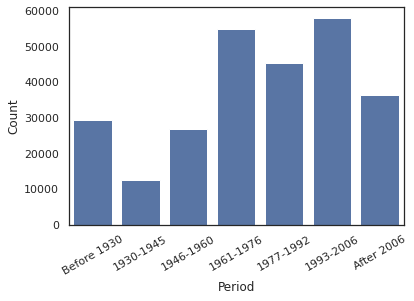

In [41]:
# Period
fig = plt.figure(figsize = (6,4))
cplot = sns.countplot(x = pd.cut(cened_old.ANNO_COSTRUZIONE, bins=[0,1930,1945,1960,1976,1992,2006,3000], 
       labels=['Before 1930','1930-1945','1946-1960','1961-1976', '1977-1992', 
               '1993-2006','After 2006']), color = 'b')
cplot.set(ylabel = 'Count', xlabel = 'Period')
plt.xticks(rotation=30)
plt.show()

# Shuffle

In [42]:
cened = cened_old.sample(frac=1).reset_index(drop=True)

# Reserve a test set

In [43]:
msk = np.random.rand(len(cened)) < 0.8
train = cened[msk]
test = cened[~msk]

In [44]:
print(len(train))

210943


In [45]:
print(len(test))

52645


# Define MAPE

In [46]:
def neg_mape(y_true, y_pred):
  y_true = np.array(y_true)
  y_pred = np.array(y_pred)
  return -np.abs((y_true - y_pred)/y_true).mean()

In [47]:
def modified_neg_mape(y_true, y_pred):
  y_true = np.array(y_true)
  y_pred = np.array(y_pred)
  errors = np.abs((y_true - y_pred)/y_true)
  index = np.argwhere(errors > 1)
  mod_errors = np.delete(errors, index)
  return -mod_errors.mean()

In [48]:
neg_mape_scorer = make_scorer(neg_mape, greater_is_better=True)

In [49]:
modified_neg_mape_scorer = make_scorer(modified_neg_mape, greater_is_better=True)

# Random search

In [50]:
mlcol = ['PERIODO','SUPERFICIE_LORDA', 'SUPERFICIE_NETTA', 'VOLUME_LORDO', 
         'VOLUME_NETTO', 'SUPERFICIE_DISPERDENTE',
         'TRASMITTANZA_MEDIA_INVOLUCRO', 'TRASMITTANZA_MEDIA_COPERTURA',
         'TRASMITTANZA_MEDIA_BASAMENTO', 'TRASMITTANZA_MEDIA_SERRAMENTO',
         'dd','SUP_FINESTRATA','SUP_OPACA', 'SUPERFICIE_VETRATA_OPACA',
         'NUMERO_RICAMBI_ORARI', 'ALTEZZA_MEDIA']

In [51]:
cat_feats = ['PERIODO']

In [53]:
param_dist = {'feature_fraction': np.linspace(0.4, 1, num=7),
              'num_leaf' : list(range(20,40)),
             'max_depth' : [-1],
             'max_bin' : [100, 200, 300, 500, 750, 1000, 2000],
             'bagging_fraction' : np.linspace(0.4, 1, num=14),
             'bagging_freq' : list(range(1,10)),
             'lambda_l1' : stats.uniform(0, 0.6),
             'lambda_l2' : stats.uniform(0, 0.6)}

lgbm = LGBMRegressor(n_estimators = 200, silent = True, verbose = 0, is_training_metric = True, n_jobs = 1, 
                     eval_metric  = 'mape')

n_iter_search = 100

random_search = RandomizedSearchCV(lgbm, param_distributions=param_dist, n_iter=n_iter_search, 
                                   scoring={'MAPE' : neg_mape_scorer, 'MAPE <100%' : modified_neg_mape_scorer, 'R2' : 'r2'} , cv = 5, n_jobs = 6, verbose = 2, refit = 'MAPE')

random_search.fit(cened[mlcol], cened['ETH'], categorical_feature = cat_feats)

Fitting 5 folds for each of 100 candidates, totalling 500 fits


[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  29 tasks      | elapsed:  2.9min
[Parallel(n_jobs=6)]: Done 150 tasks      | elapsed: 15.2min
[Parallel(n_jobs=6)]: Done 353 tasks      | elapsed: 36.9min
[Parallel(n_jobs=6)]: Done 500 out of 500 | elapsed: 51.3min finished
/usr/local/lib/python3.6/dist-packages/lightgbm/basic.py:1209: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['PERIODO']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))


RandomizedSearchCV(cv=5, error_score=nan,
                   estimator=LGBMRegressor(boosting_type='gbdt',
                                           class_weight=None,
                                           colsample_bytree=1.0,
                                           eval_metric='mape',
                                           importance_type='split',
                                           is_training_metric=True,
                                           learning_rate=0.1, max_depth=-1,
                                           min_child_samples=20,
                                           min_child_weight=0.001,
                                           min_split_gain=0.0, n_estimators=200,
                                           n_jobs=1, num_leaves=31,
                                           objective=None, random_sta...
                                        'lambda_l2': <scipy.stats._distn_infrastructure.rv_frozen object at 0x7fb818263278>,
            

# Print results

In [54]:
print(random_search.best_params_)

{'bagging_fraction': 0.9076923076923077, 'bagging_freq': 4, 'feature_fraction': 0.7, 'lambda_l1': 0.29723981452145637, 'lambda_l2': 0.2711056858325474, 'max_bin': 500, 'max_depth': -1, 'num_leaf': 29}


In [55]:
print(random_search.best_score_)

-0.12717502144883597


In [56]:
# Create a results df
cv_df = pd.DataFrame(random_search.cv_results_)
cv_df = cv_df.sort_values(by = ['rank_test_MAPE']).reset_index()

# Filter columns
res_cols = [col for col in cv_df if col.startswith('split')]

# Select best iter
best_res = cv_df.loc[0]

# Print results for each fold
print(best_res[res_cols])

split0_test_MAPE           -0.1281
split1_test_MAPE         -0.126483
split2_test_MAPE         -0.128085
split3_test_MAPE         -0.126813
split4_test_MAPE         -0.126394
split0_test_MAPE <100%   -0.122759
split1_test_MAPE <100%   -0.122074
split2_test_MAPE <100%   -0.122792
split3_test_MAPE <100%   -0.121733
split4_test_MAPE <100%   -0.122122
split0_test_R2            0.935432
split1_test_R2            0.937043
split2_test_R2            0.936762
split3_test_R2            0.937437
split4_test_R2            0.936388
Name: 0, dtype: object


In [76]:
# Best R2
print(best_res.mean_test_R2)

0.9366125726068214


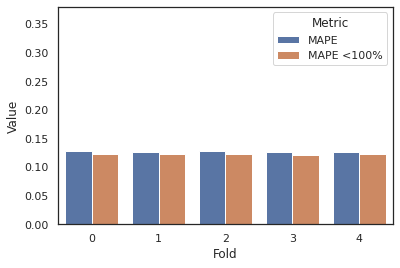

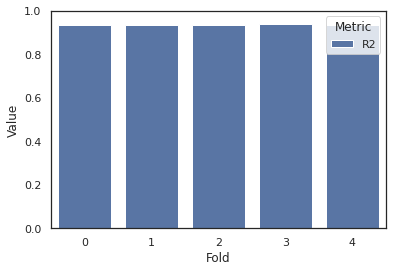

In [57]:
df = pd.DataFrame(best_res[res_cols])
df = df.rename(columns = {0:'Value'})
df['Fold'] = df.index.str[5:6]
df['Metric'] = df.index.str[12:]
df['Value'] = np.where(df['Metric'] == 'R2', df['Value'], df['Value'] * -1)
ax = sns.barplot(x='Fold', y="Value", hue="Metric", data = df[df['Metric'] != 'R2'])
ax.set(ylim = (0, 0.38))
plt.show()
ax = sns.barplot(x='Fold', y="Value", hue="Metric", data = df[df['Metric'] == 'R2'])
ax.set(ylim = (0, 1))
plt.show()

# Train the final model

In [77]:
light = LGBMRegressor(n_estimators = 1000, silent = False, verbose = 2, is_training_metric = True, n_jobs = 6)
light.set_params(**random_search.best_params_)

LGBMRegressor(bagging_fraction=0.9076923076923077, bagging_freq=4,
              boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
              feature_fraction=0.7, importance_type='split',
              is_training_metric=True, lambda_l1=0.29723981452145637,
              lambda_l2=0.2711056858325474, learning_rate=0.1, max_bin=500,
              max_depth=-1, min_child_samples=20, min_child_weight=0.001,
              min_split_gain=0.0, n_estimators=1000, n_jobs=6, num_leaf=29,
              num_leaves=31, objective=None, random_state=None, reg_alpha=0.0,
              reg_lambda=0.0, silent=False, subsample=1.0,
              subsample_for_bin=200000, subsample_freq=0, verbose=2)

In [78]:
light.fit(train[mlcol], train['ETH'], categorical_feature = cat_feats)

/usr/local/lib/python3.6/dist-packages/lightgbm/basic.py:1209: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['PERIODO']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))


LGBMRegressor(bagging_fraction=0.9076923076923077, bagging_freq=4,
              boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
              feature_fraction=0.7, importance_type='split',
              is_training_metric=True, lambda_l1=0.29723981452145637,
              lambda_l2=0.2711056858325474, learning_rate=0.1, max_bin=500,
              max_depth=-1, min_child_samples=20, min_child_weight=0.001,
              min_split_gain=0.0, n_estimators=1000, n_jobs=6, num_leaf=29,
              num_leaves=31, objective=None, random_state=None, reg_alpha=0.0,
              reg_lambda=0.0, silent=False, subsample=1.0,
              subsample_for_bin=200000, subsample_freq=0, verbose=2)

# Test the model

In [79]:
y_pred = light.predict(test[mlcol]).clip(0)

In [80]:
results_df = pd.DataFrame({'predicted' : y_pred, 'true' : test['ETH']})
results_df['error'] = np.abs((results_df['true'] - results_df['predicted'])/results_df['true'])*100

In [81]:
# MAPE
results_df['error'].mean()

11.858495462453504

In [82]:
# Max % error
results_df['error'].max()

497.84200699953607

In [83]:
# Row with the highest % error
results_df.iloc[results_df['error'].argmax()]

predicted     83.106615
true          13.901100
error        497.842007
Name: 3513, dtype: float64

In [84]:
# MAPE without >100%
results_df[results_df.error <= 100].error.mean()

11.502579106779825

In [85]:
# R2 
print(r2_score(test['ETH'], y_pred))

0.9442097614564383


In [86]:
# R2 without >100%
print(r2_score(results_df[results_df.error <= 100].true, results_df[results_df.error <= 100].predicted))

0.9461233936964898


In [87]:
results_df

,predicted,true,error
2,259.247425,266.2976,2.647480
3,144.735789,129.6703,11.618303
8,51.945032,44.6759,16.270814
9,292.963488,296.6496,1.242581
12,310.396311,222.4868,39.512237
...,...,...,...
263552,90.689514,108.7139,16.579652
263560,38.618725,47.3399,18.422463
263566,65.854293,63.7643,3.277685
263575,161.996447,151.3966,7.001377


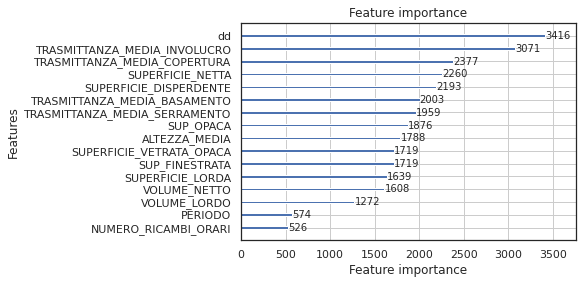

In [88]:
plot_importance(light)

# Error analysis

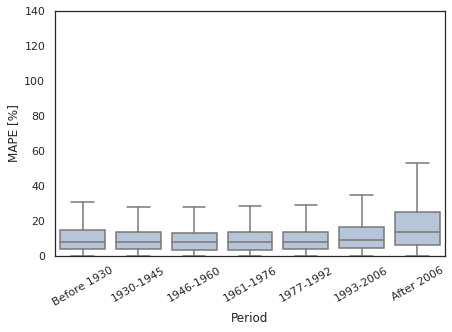

In [92]:
# Period
bins = pd.cut(test.ANNO_COSTRUZIONE, bins=[0,1930,1945,1960,1976,1992,2006,3000], 
       labels=['Before 1930','1930-1945','1946-1960','1961-1976', '1977-1992', 
               '1993-2006','After 2006'])

fig = plt.figure(figsize = (7, 4.5))
box = sns.boxplot(y = results_df.error, x = bins, 
                  color='lightsteelblue', orient = 'v', 
                  showfliers = False)

box.set(ylim = (0, 140), ylabel = 'MAPE [%]', xlabel = 'Period')
plt.xticks(rotation=30)
plt.show()

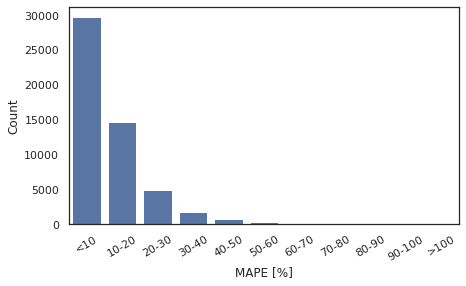

In [90]:
# Error
fig = plt.figure(figsize = (7,4))
cplot = sns.countplot(x = pd.cut(results_df.error, bins=[0,10,20,30,40,50,60,70,80,90,100,10000],
                                 labels = ['<10', '10-20', '20-30', '30-40', '40-50', '50-60', '60-70', '70-80', '80-90', '90-100', '>100']), color = 'b')
cplot.set(ylabel = 'Count', xlabel = 'MAPE [%]')
plt.xticks(rotation=30)
plt.show()

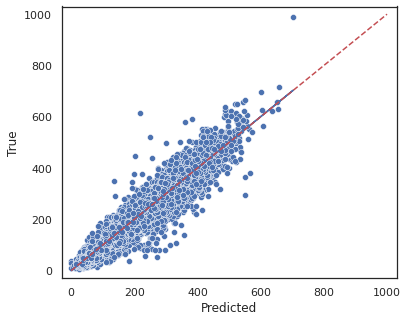

In [91]:
# Scatterplot
fig = plt.figure(figsize = (6,5))
scatter = sns.scatterplot(data=results_df, x="predicted", y="true")
scatter.set(ylabel = 'True', xlabel = 'Predicted',
            xlim=(-30, 1030), ylim=(-30, 1030))
m, b = np.polyfit(results_df['predicted'], results_df['true'], 1)
plt.plot(results_df['predicted'].values, m*results_df['predicted'] + b)
plt.plot([0, 1000], [0,1000], c = 'r', linestyle='--')
plt.show()